In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [9]:
# Load the dataset
df = pd.read_csv("data_news - data_news.csv")

df.head()

,category,headline,links,short_description,keywords
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running-lessons
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug
3,WELLNESS,"Oh, What a Difference She Made",https://www.huffingtonpost.com/entry/meaningfu...,"If you want to be busy, keep trying to be perf...",meaningful-life
4,WELLNESS,Green Superfoods,https://www.huffingtonpost.com/entry/green-sup...,"First, the bad news: Soda bread, corned beef a...",green-superfoods


## **Data Preprocessing**

In [10]:
def preprocess_text(text):
    """Clean and preprocess text data"""
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove special characters, numbers, and extra spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize and remove stopwords
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Combine headline and description
df['full_text'] = df['headline'] + ' ' + df['short_description']

# Handle missing values
df['full_text'] = df['full_text'].fillna('')
df['category'] = df['category'].fillna('UNKNOWN')

# Preprocess text
df['processed_text'] = df['full_text'].apply(preprocess_text)

# **Exploratory Data Analysis (EDA)**

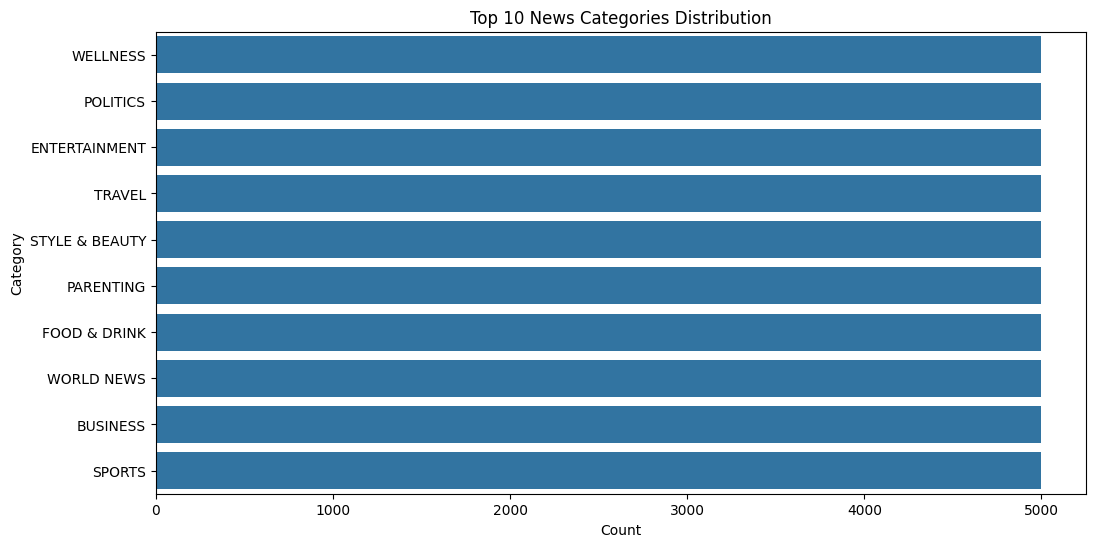

In [11]:
plt.figure(figsize=(12, 6))
category_counts = df['category'].value_counts().head(10)  # Top 10 categories
sns.barplot(x=category_counts.values, y=category_counts.index)
plt.title('Top 10 News Categories Distribution')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

# **Feature Extraction with TF-IDF**

In [12]:
# Focus on top 10 categories for better performance
top_categories = category_counts.index.tolist()
df_top = df[df['category'].isin(top_categories)]

In [14]:
# Split dataset
X = df_top['processed_text']
y = df_top['category']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.7
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# **Model Development and Training**

In [15]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', probability=True, random_state=42)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [17]:
from sklearn.linear_model import SGDClassifier
import time

# 1. Reduce Feature Dimensions (because privious code "10000" take a lot of time to run)
tfidf = TfidfVectorizer(
    max_features=5000,  # Reduced from 10,000
    ngram_range=(1, 1),  # Use only unigrams
    min_df=10,           # Increased min frequency
    max_df=0.8,
    sublinear_tf=True    # Use sublinear TF scaling
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# 2. Use Faster Models and Parallel Processing
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=500,
        random_state=42,
        n_jobs=-1,  # Use all CPU cores
        solver='saga'
    ),
    'Naive Bayes': MultinomialNB(alpha=0.1),
    'SVM (Linear)': SGDClassifier(  # Faster alternative to SVC
        loss='hinge',
        penalty='l2',
        alpha=1e-4,
        max_iter=1000,
        random_state=42,
        n_jobs=-1
    )
}

# 3. Optimized Training Loop
results = {}
for name, model in models.items():
    print(f"Training {name}...")

    # Train without cross-validation first
    start_time = time.time()
    model.fit(X_train_tfidf, y_train)
    train_time = time.time() - start_time

    # Fast prediction
    y_pred = model.predict(X_test_tfidf)

    # Limited cross-validation (3 folds)
    cv_scores = cross_val_score(
        model,
        X_train_tfidf,
        y_train,
        cv=3,  # Reduced from 5 folds
        scoring='accuracy',
        n_jobs=-1
    )

    results[name] = {
        'test_accuracy': accuracy_score(y_test, y_pred),
        'cv_mean_accuracy': np.mean(cv_scores),
        'train_time_sec': train_time,
        'model': model
    }
    print(f"{name} - Train Time: {train_time:.1f}s, Test Acc: {results[name]['test_accuracy']:.4f}")

# 4. Compare results
model_comparison = pd.DataFrame({
    'Model': results.keys(),
    'Test Accuracy': [results[m]['test_accuracy'] for m in results],
    'CV Accuracy': [results[m]['cv_mean_accuracy'] for m in results],
    'Train Time (s)': [results[m]['train_time_sec'] for m in results]
}).sort_values('Test Accuracy', ascending=False)

Training Logistic Regression...
Logistic Regression - Train Time: 4.5s, Test Acc: 0.7950
Training Naive Bayes...
Naive Bayes - Train Time: 0.3s, Test Acc: 0.7715
Training SVM (Linear)...
SVM (Linear) - Train Time: 1.2s, Test Acc: 0.7918


# **Model Evaluation and Comparison**

In [18]:
# Compare model performance
model_comparison = pd.DataFrame({
    'Model': results.keys(),
    'CV Accuracy': [results[m]['cv_mean_accuracy'] for m in results],
    'Test Accuracy': [results[m]['test_accuracy'] for m in results]
}).sort_values('Test Accuracy', ascending=False)

print("\nModel Performance Comparison:")
print(model_comparison)


Model Performance Comparison:
                 Model  CV Accuracy  Test Accuracy
0  Logistic Regression     0.792050         0.7950
2         SVM (Linear)     0.792625         0.7918
1          Naive Bayes     0.767625         0.7715


In [19]:
# Detailed evaluation for best model
best_model_name = model_comparison.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\nBest Model: {best_model_name}")
print(classification_report(y_test, best_model.predict(X_test_tfidf), zero_division=0))


Best Model: Logistic Regression
                precision    recall  f1-score   support

      BUSINESS       0.74      0.77      0.75      1000
 ENTERTAINMENT       0.78      0.77      0.78      1000
  FOOD & DRINK       0.84      0.86      0.85      1000
     PARENTING       0.76      0.77      0.77      1000
      POLITICS       0.76      0.74      0.75      1000
        SPORTS       0.88      0.89      0.88      1000
STYLE & BEAUTY       0.88      0.83      0.85      1000
        TRAVEL       0.79      0.78      0.78      1000
      WELLNESS       0.71      0.76      0.74      1000
    WORLD NEWS       0.82      0.78      0.80      1000

      accuracy                           0.80     10000
     macro avg       0.80      0.79      0.80     10000
  weighted avg       0.80      0.80      0.80     10000



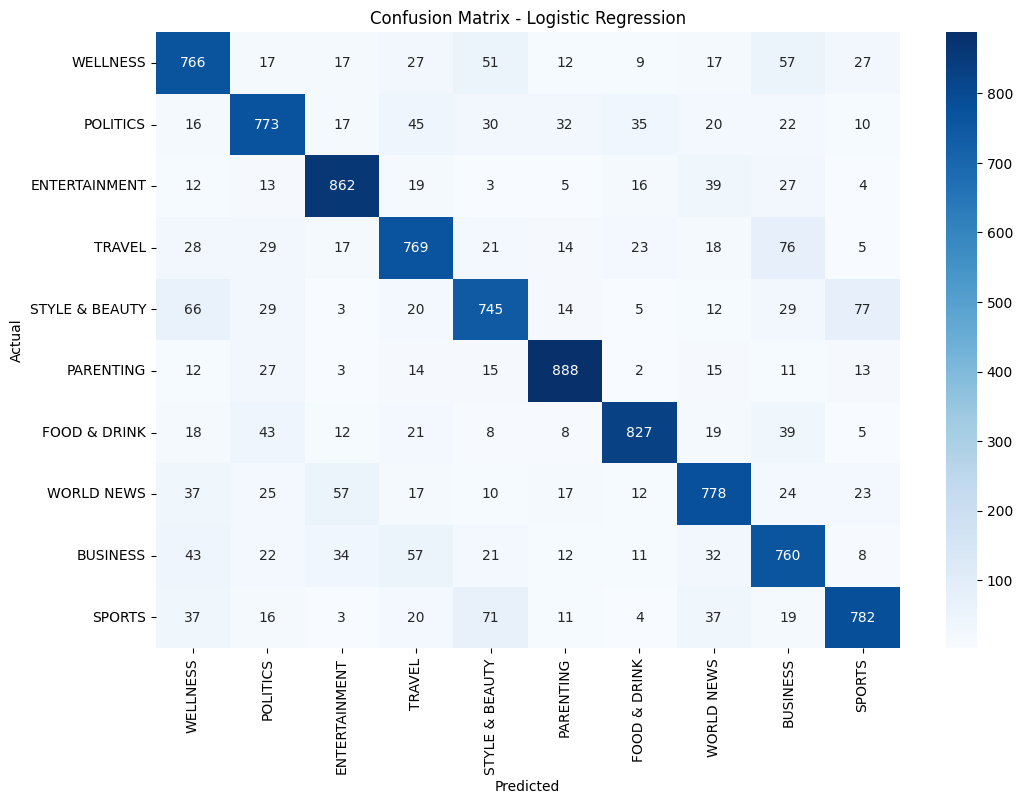

In [20]:
# Confusion Matrix for best model
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, best_model.predict(X_test_tfidf))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=top_categories,
            yticklabels=top_categories)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **Hyperparameter Tuning**

In [21]:
if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1, 10],
        'solver': ['lbfgs', 'saga'],
        'penalty': ['l2', 'none']
    }
    grid_search = GridSearchCV(
        LogisticRegression(max_iter=1000, random_state=42),
        param_grid,
        cv=cv,
        scoring='accuracy'
    )
    grid_search.fit(X_train_tfidf, y_train)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV accuracy: {grid_search.best_score_:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_

Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best CV accuracy: 0.7977


In [25]:
# Save best model
import joblib
joblib.dump(best_model, 'best_news_classifier.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']